#### Import Lib


In [17]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Đọc dữ liệu


In [18]:
df_real = pd.read_csv('../Data/input_data.csv')
df = df_real.copy()

In [19]:
# Hàm loại bỏ giá trị ngoại lai
def remove_outliers(df, columns=None):
    """
    Loại bỏ giá trị ngoại lai khỏi các cột được chỉ định trong DataFrame.
    - df: DataFrame đầu vào
    - columns: Danh sách các cột cần kiểm tra (nếu None, sẽ kiểm tra tất cả các cột số)
    """
    if columns is None:
        columns = df.select_dtypes(include=['float', 'int']).columns  # Chỉ lấy các cột số

    for col in columns:
        # Tính IQR (Interquartile Range)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Xác định phạm vi hợp lệ
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Loại bỏ ngoại lai
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Áp dụng hàm
df = remove_outliers(df)

In [20]:
df.columns

Index(['Brand', 'Processor_Name', 'Processor_Brand', 'RAM', 'RAM_TYPE',
       'Display_type', 'GPU', 'GPU_Brand', 'SSD', 'OS', 'VRAM', 'Price_VND'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 0 to 3915
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Brand            3034 non-null   object
 1   Processor_Name   3034 non-null   object
 2   Processor_Brand  3034 non-null   object
 3   RAM              3034 non-null   int64 
 4   RAM_TYPE         3034 non-null   object
 5   Display_type     3034 non-null   object
 6   GPU              3034 non-null   object
 7   GPU_Brand        3034 non-null   object
 8   SSD              3034 non-null   int64 
 9   OS               3034 non-null   object
 10  VRAM             3034 non-null   int64 
 11  Price_VND        3034 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 308.1+ KB


#### Train - Test Split


In [22]:
# Giả sử dữ liệu của bạn có tên là df
X = df.drop('Price_VND', axis=1)  # Các biến độc lập
y = df['Price_VND']  # Biến mục tiêu

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Xác định biến số và biến phân loại
# Xác định các biến số và biến phân loại
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#### Tạo Pipeline tiền xử lý


In [24]:
# Tạo pipeline cho tiền xử lý
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp các bước tiền xử lý vào ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Xây dựng Pipeline cho mô hình hồi quy


In [25]:
# Danh sách các mô hình hồi quy
models = {
    'XGBRegressor': XGBRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'KNeighborsRegressor': KNeighborsRegressor()
}

# Huấn luyện và đánh giá mô hình
results = {}

for model_name, model in models.items():
    # Tạo pipeline cho mô hình
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Huấn luyện mô hình
    pipeline.fit(X_train, y_train)
    
    # Dự đoán trên tập train và tập test
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # # Đánh giá mô hình trên tập train
    # train_mae = mean_absolute_error(y_train, y_train_pred)
    # train_mse = mean_squared_error(y_train, y_train_pred)
    # train_r2 = r2_score(y_train, y_train_pred)
    
    # Đánh giá mô hình trên tập test
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # # Lưu kết quả đánh giá
    # results[model_name] = {
    #     'Train MAE': train_mae, 'Test MAE': test_mae,
    #     'Train MSE': train_mse, 'Test MSE': test_mse,
    #     'Train R2': train_r2,   'Test R2': test_r2
    # }
    results[model_name] = {
        'MAE': test_mae,
        'MSE': test_mse,
        'R2': test_r2
    }

# Hiển thị kết quả
results_df = pd.DataFrame(results).T
results_df


,MAE,MSE,R2
XGBRegressor,2.207033e+06,9.270887e+12,0.770631
DecisionTreeRegressor,2.708581e+06,1.523497e+13,0.623075
RandomForestRegressor,2.387452e+06,1.114195e+13,0.724340
LinearRegression,2.317085e+06,9.790896e+12,0.757766
Ridge,2.308289e+06,9.788094e+12,0.757835
KNeighborsRegressor,2.674143e+06,1.436497e+13,0.644600


In [26]:
# # Danh sách các mô hình hồi quy
# models = {
#     'XGBRegressor': XGBRegressor(),
#     'DecisionTreeRegressor': DecisionTreeRegressor(),
#     'RandomForestRegressor': RandomForestRegressor(),
#     'LinearRegression': LinearRegression(),
#     'Ridge': Ridge(),
#     'KNeighborsRegressor': KNeighborsRegressor()
# }

# # Huấn luyện và đánh giá mô hình
# results = {}

# for model_name, model in models.items():
#     # Tạo pipeline cho mô hình
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                ('regressor', model)])
    
#     # Huấn luyện mô hình
#     pipeline.fit(X_train, y_train)
    
#     # Dự đoán trên tập kiểm tra
#     y_pred = pipeline.predict(X_test)
    
#     # Đánh giá mô hình
#     mae = mean_absolute_error(y_test, y_pred)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     # Lưu kết quả đánh giá
#     results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

# # Hiển thị kết quả
# results_df = pd.DataFrame(results).T
# results_df


Kết quả:

- Mô hình tốt nhất: XGBRegressor có R² cao nhất (81.8%) và MAE thấp, làm cho nó trở thành mô hình tốt nhất trong bộ so sánh này.
- Mô hình kém nhất: KNeighborsRegressor có R² thấp nhất (78.4%) và MSE cao nhất, cho thấy nó không phù hợp với dữ liệu này so với các mô hình khác.

Hướng phát triển:

- Tối ưu tham số cho mô hình XGBRegressor


#### Tối ưu tham số cho mô hình XGBRegressor


In [27]:
# Danh sách một số param cần lưu ý
xgb_params = {
    'n_estimators',        # Số lượng cây quyết định
    'learning_rate',       # Tốc độ học (eta)
    'max_depth',             # Độ sâu tối đa của cây
    'min_child_weight',      # Trọng số tối thiểu của mỗi nút lá
    'subsample',           # Tỷ lệ mẫu huấn luyện mỗi cây
    'colsample_bytree',    # Tỷ lệ đặc trưng được chọn để huấn luyện mỗi cây
    'gamma',                 # Mức độ phạt để ngừng tạo nhánh
    'scale_pos_weight',      # Tỷ lệ giữa các lớp trong bài toán mất cân bằng
    'objective',  # Mục tiêu hồi quy
    'eval_metric',      # Chỉ số đánh giá
    'tree_method',      # Phương pháp xây dựng cây
    'lambda',              # Regularization L2 (Ridge)
    'alpha'               # Regularization L1 (Lasso)
}


In [28]:
# Xây dựng Pipeline riêng cho mô hình XGBRegressor
XGB_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor())  # Mô hình XGBRegressor
    ]
)

# Huấn luyện lại mô hình với tham số mặc định
XGB_pipeline.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình với tham số mặc định
y_pred = XGB_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In ra các kết quả đánh giá và tham số mặc định
print("Kết quả đánh giá với tham số mặc định:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")
# XGB_pipeline.named_steps['regressor'].get_params()

# Tạo DataFrame từ y_test và y_pred
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})


# In ra các tham số có trong danh sách xgb_params
print("\nCác tham số của XGBRegressor trong danh sách cần lưu ý:")
xgb_model_params = XGB_pipeline.named_steps['regressor'].get_params()

for param in xgb_params:
    if param in xgb_model_params:
        print(f"{param}: {xgb_model_params[param]}")


Kết quả đánh giá với tham số mặc định:
MAE: 2207033.0366556835
MSE: 9270887279339.035
R²: 0.7706312012544468

Các tham số của XGBRegressor trong danh sách cần lưu ý:
objective: reg:squarederror
subsample: None
max_depth: None
eval_metric: None
scale_pos_weight: None
colsample_bytree: None
tree_method: None
min_child_weight: None
gamma: None
n_estimators: None
learning_rate: None


In [29]:
# Hàm dự đoán giá bán laptop
def predict_laptop_price(brand, processor_name, processor_brand, ram, ram_type, display_type, gpu, gpu_brand, ssd, os, vram):
    # Tạo DataFrame cho dữ liệu nhập
    input_data = pd.DataFrame({
        'Brand': [brand],
        'Processor_Name': [processor_name],
        'Processor_Brand': [processor_brand],
        'RAM': [ram],
        'RAM_TYPE': [ram_type],
        'Display_type': [display_type],
        'GPU': [gpu],
        'GPU_Brand': [gpu_brand],
        'SSD': [ssd],
        'OS': [os],
        'VRAM': [vram]
    })
    
    # Dự đoán giá bán
    predicted_price = XGB_pipeline.predict(input_data)
    return predicted_price[0]

# Ví dụ sử dụng hàm
predicted_price = predict_laptop_price(
    brand='Lenovo', processor_name='AMD Octa-Core Ryzen 7', processor_brand='AMD', ram=16, ram_type='DDR5', 
    display_type='LCD', gpu='Geforce RTX 4060', gpu_brand='NVIDIA', ssd=512, os='Windows 11', vram=8
)

print(f"Giá bán dự đoán của laptop là: {predicted_price} VND")

Giá bán dự đoán của laptop là: 21275050.0 VND


In [30]:
df[df['Processor_Name'].str.contains('Ryzen 7')]['Processor_Name'].unique()


array(['AMD Octa-Core Ryzen 7', 'AMD Octa-Core Ryzen 7 Processor',
       'AMD Quad-Core Ryzen 7', 'AMD Octa-Core Ryzen 7 Pro'], dtype=object)

In [31]:
results_df

,Actual,Predicted
3699,24897000,21028382.0
2903,10267500,10410747.0
3105,24120000,18003924.0
490,11610000,13445709.0
1079,17697000,17854176.0
...,...,...
3442,11817000,13825256.0
3520,24297000,18837386.0
3176,13052100,17303804.0
799,12075000,14382863.0


K=2: MAE=2356832.6684, MSE=10307982722506.9297, R2=0.7372
K=3: MAE=2319876.8403, MSE=10194849661002.7012, R2=0.7402
K=4: MAE=2272957.4906, MSE=9808443585104.7793, R2=0.7500
K=5: MAE=2279409.7247, MSE=9852135981685.6855, R2=0.7485
K=6: MAE=2252909.0619, MSE=9555859060923.4258, R2=0.7559
K=7: MAE=2251940.5727, MSE=9602106050178.5098, R2=0.7546
K=8: MAE=2253689.9403, MSE=9524835751948.4688, R2=0.7564
K=9: MAE=2238015.1254, MSE=9468976318741.5762, R2=0.7576
K=10: MAE=2221889.9330, MSE=9331093799363.0645, R2=0.7610
K=11: MAE=2245737.5424, MSE=9538178756404.0391, R2=0.7556
K=12: MAE=2221818.6669, MSE=9395068284777.3203, R2=0.7597
K=13: MAE=2238305.7594, MSE=9528606445532.3301, R2=0.7567
K=14: MAE=2233325.0517, MSE=9418734902873.5234, R2=0.7583
K=15: MAE=2218821.6388, MSE=9357021041239.4316, R2=0.7609


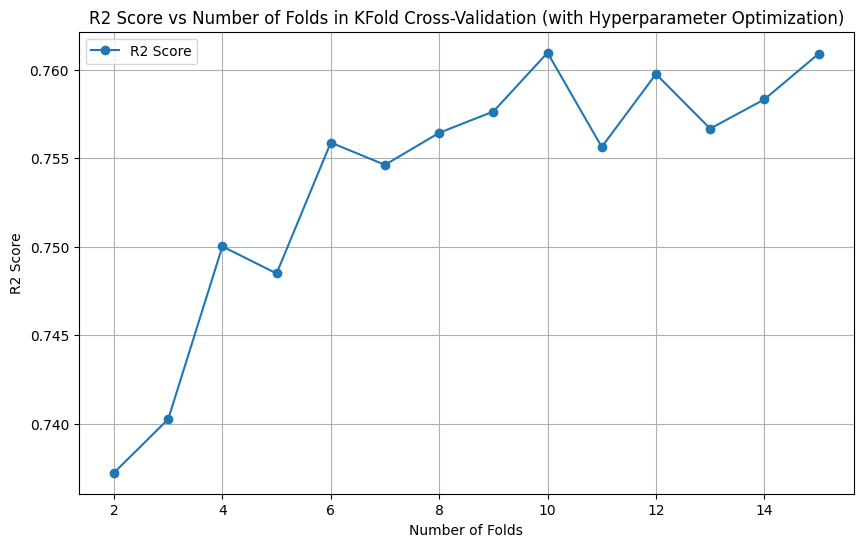

In [32]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Tạo DataFrame lưu kết quả
kfold_results = []

# Danh sách hyperparameters cần tối ưu hóa
param_grid = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Vòng lặp qua số lượng folds từ 2 đến 15
for num_folds in range(2, 16):
    skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Tối ưu hóa hyperparameters bằng GridSearchCV
        grid_search = GridSearchCV(
            estimator=XGB_pipeline,
            param_grid=param_grid,
            cv=3,  # Sử dụng 3-fold cross-validation trong GridSearchCV
            scoring='r2',
            n_jobs=-1  # Sử dụng tất cả các CPU khả dụng
        )
        grid_search.fit(X_train, y_train)

        # Lấy pipeline tốt nhất sau tối ưu hóa
        best_pipeline = grid_search.best_estimator_

        # Dự đoán và đánh giá
        y_pred = best_pipeline.predict(X_test)
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    # Lưu kết quả trung bình của từng số folds
    kfold_results.append({
        'num_folds': num_folds,
        'mean_mae': np.mean(mae_scores),
        'mean_mse': np.mean(mse_scores),
        'mean_r2': np.mean(r2_scores)
    })

# In kết quả
for result in kfold_results:
    print(f"K={result['num_folds']}: MAE={result['mean_mae']:.4f}, MSE={result['mean_mse']:.4f}, R2={result['mean_r2']:.4f}")

# (Tùy chọn) Vẽ biểu đồ sự thay đổi của R2 theo số lượng folds
folds = [res['num_folds'] for res in kfold_results]
r2_values = [res['mean_r2'] for res in kfold_results]

plt.figure(figsize=(10, 6))
plt.plot(folds, r2_values, marker='o', label='R2 Score')
plt.title('R2 Score vs Number of Folds in KFold Cross-Validation (with Hyperparameter Optimization)')
plt.xlabel('Number of Folds')
plt.ylabel('R2 Score')
plt.grid(True)
plt.legend()
plt.show()


In [34]:
print("Kết quả tối ưu hóa hyperparameters:")
print(grid_search.best_params_)

Kết quả tối ưu hóa hyperparameters:
{'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}


In [35]:
# Lấy pipeline tốt nhất sau tối ưu hóa
best_pipeline = grid_search.best_estimator_

# Dự đoán trên tập train và test
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Đánh giá trên tập train
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Đánh giá trên tập test
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# In ra các thông số đánh giá
print("Đánh giá mô hình tốt nhất sau tối ưu hóa:")
print("=== Tập Train ===")
print(f"MAE (Train): {train_mae:.4f}")
print(f"MSE (Train): {train_mse:.4f}")
print(f"R² (Train): {train_r2:.4f}")
print("\n=== Tập Test ===")
print(f"MAE (Test): {test_mae:.4f}")
print(f"MSE (Test): {test_mse:.4f}")
print(f"R² (Test): {test_r2:.4f}")

# In ra các tham số của mô hình tốt nhất
print("\nCác tham số của mô hình tốt nhất:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")


Đánh giá mô hình tốt nhất sau tối ưu hóa:
=== Tập Train ===
MAE (Train): 1798812.8878
MSE (Train): 6035436893361.0498
R² (Train): 0.8466

=== Tập Test ===
MAE (Test): 2032229.4641
MSE (Test): 7001904452345.2910
R² (Test): 0.8116

Các tham số của mô hình tốt nhất:
regressor__colsample_bytree: 0.8
regressor__learning_rate: 0.1
regressor__max_depth: 5
regressor__n_estimators: 300
regressor__subsample: 1.0


In [33]:
# # Cross-validation bằng Stratified K-Fold với 11 folds
# num_folds = 10
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
# mae_scores = []
# mse_scores = []
# r2_scores = []

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     XGB_pipeline.fit(X_train, y_train)
#     y_pred = XGB_pipeline.predict(X_test)
#     mae_scores.append(mean_absolute_error(y_test, y_pred))
#     mse_scores.append(mean_squared_error(y_test, y_pred))
#     r2_scores.append(r2_score(y_test, y_pred))

# print("MAE của các fold:", mae_scores)
# print("MAE trung bình:", np.mean(mae_scores))
# print("MSE của các fold:", mse_scores)
# print("MSE trung bình:", np.mean(mse_scores))
# print("R2 của các fold:", r2_scores)
# print("R2 trung bình:", np.mean(r2_scores))